In [9]:
import cirq
import numpy as np
import random as rand
import matplotlib.pyplot as plt
import isingCircuit as ic

from cirq import Circuit, ops, linalg, protocols
from cirq.devices import GridQubit
from cirq.google import XmonSimulator

# Quantum Compression


## Introduction
Goal: Simulate an Ising chain of $n$-qubits, using only $\log n$ qubits. Specifically, the paper does a four qubit Ising chain using two qubits. We must decompose the circuits for compressed simulation into the available gate set. We must also run the experiment often enough so that statistical errors are reduced. Systematic errors must be estimated using independent controlled circuits of similar complexity to the one of interest. Since we are running in simulation via Cirq, this may be less of an issue.

We use the following set up in Cirq for the rest of the tutorial:

In [2]:
qubits = cirq.LineQubit.range(3)
qubit0, qubit1, qubit2 = qubits

circuit = cirq.Circuit()

## Step 1
Prepare the input state $\rho_{i n} = \frac{1}{2^{m-1}} I^{\otimes m-1} \otimes |+_{y} \rangle \langle+_{y} |$ where $Y |+_{y} \rangle=|+_{y} \rangle$ by applying $S^{\dagger}H$ on qubit $0$, $H$ on an auxilirary qubit $2$, and $CNOT$ on qubits $1$ and $2$ with qubit $1$ being the target and qubit $2$ the control.

In [3]:
circuit.append([cirq.H(qubit0)])
circuit.append([cirq.S(qubit0)**-1])
circuit.append([cirq.H(qubit2)])
circuit.append([cirq.CNOT(control=qubit2, target=qubit1)])

circuit

0: ───H───S^-1───

1: ───────X──────
          │
2: ───H───@──────

## Step 2

Evolve the system up to the desired value of $J$, which in this case is $J = 1$, by decomposing the evolutionary operator $W(J)=\prod_{l=1}^{L(J)} U_{d} R_{l}^{T} R_{0}^{T}$ into the Clifford+T gate set. This is done, rather than decomposing each step in the adiabatic evolution $U_{d} R_{l}^{T} R_{0}^{T}$, in order to keep the total circuit depth practically feasible.

In [4]:
circuit.append([cirq.H(qubit0)])
circuit.append([cirq.CNOT(control=qubit0, target=qubit1)])
circuit.append([cirq.Z(qubit0)])
circuit.append([cirq.H(qubit0)])
circuit.append([cirq.CNOT(control=qubit0, target=qubit1)])
circuit.append([cirq.S(qubit0)])
circuit.append([cirq.T(qubit1)])
circuit.append([cirq.H(qubit0)])
circuit.append([cirq.Z(qubit1)])
circuit.append([cirq.CNOT(control=qubit0, target=qubit1)])
circuit.append([cirq.T(qubit0)])
circuit.append([cirq.H(qubit0)])
circuit.append([cirq.T(qubit0)])

circuit

0: ───H───S^-1───H───@───Z───H───@───S───H───@───T───H───T───
                     │           │           │
1: ───────X──────────X───────────X───T───Z───X───────────────
          │
2: ───H───@──────────────────────────────────────────────────

Apply $(THS)^4$ on qubit $0$:

In [5]:
for _ in range(4):
    circuit.append([cirq.S(qubit0)])
    circuit.append([cirq.H(qubit0)])
    circuit.append([cirq.T(qubit0)])

circuit

0: ───H───S^-1───H───@───Z───H───@───S───H───@───T───H───T───S───H───T───S───H───T───S───H───T───S───H───T───
                     │           │           │
1: ───────X──────────X───────────X───T───Z───X───────────────────────────────────────────────────────────────
          │
2: ───H───@──────────────────────────────────────────────────────────────────────────────────────────────────

In [6]:
circuit.append([cirq.H(qubit0)])
circuit.append([cirq.T(qubit0)])
circuit.append([cirq.H(qubit0)])
circuit.append([cirq.T(qubit0)**-1])
circuit.append([cirq.H(qubit0)])
circuit.append([cirq.T(qubit0)**-1])
circuit.append([cirq.H(qubit0)])
circuit.append([cirq.T(qubit0)])
circuit.append([cirq.Z(qubit0)])
circuit.append([cirq.H(qubit0)])

circuit

0: ───H───S^-1───H───@───Z───H───@───S───H───@───T───H───T───S───H───T───S───H───T───S───H───T───S───H───T───H───T───H───T^-1───H───T^-1───H───T───Z───H───
                     │           │           │
1: ───────X──────────X───────────X───T───Z───X─────────────────────────────────────────────────────────────────────────────────────────────────────────────
          │
2: ───H───@────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

## Step 3

Measure $Y$ on qubit $m$ to obtain the magnetization. In this case, $m = \log_{2}(4) - 1 = 1$. By nature of the rotation matrices in the matchgate circuit construction (Jozsa et al.), the $Z$ expectation of qubit $0$ after the circuit has completed $\langle Z_{0} \rangle$ is equal to the $Y$ expectation of qubit $m$ $\langle Y_{m} \rangle$, so a standard basis measurement made. Measuring the state $|0\rangle$ will correspond to an eigenvalue of $+1$ and the state $|1\rangle$ to an eigenvalue of $-1$. The expectation is equal to $\langle Y_{m} \rangle = -M(J)$, the magnetization as a function of $J$ (Hebenstreait et al.).

### Wave Function


Preserve the wave function of the system prior to measurement:

In [7]:
simulator = cirq.Simulator()
wave_function = simulator.simulate(circuit, qubit_order=qubits)

In [8]:
wave_function

measurements: (no measurements)
output vector: (-0.258-0.393j)|000⟩ + (0.393-0.258j)|001⟩ + (-0.096+0.46j)|010⟩ + (0.46+0.096j)|011⟩ + (-0.133+0.107j)|100⟩ + (-0.107-0.133j)|101⟩ + (0.169+0.018j)|110⟩ + (0.018-0.169j)|111⟩

Calculate the magnetization $M(J)$ from the wave function by decomposing the final state into the $+1$ and $-1$ eigenstates, determining the total probability for each, and computing the expectation $\langle Y_{m} \rangle$:

In [9]:
final_state = wave_function.final_state

p_1_wfn = (sum([np.absolute(i)**2 for i in final_state[0:4]]))
p_n1_wfn = (sum([np.absolute(i)**2 for i in final_state[4:8]]))

Y_wfn = 1 * p_1_wfn + -1 * p_n1_wfn

M_wfn = -Y_wfn
M_wfn

-0.7683054202225357

# Measured Outcome

Apply the standard basis measurement operator to qubit $0$:

In [10]:
circuit.append([cirq.measure(qubit0, key='x')])
circuit

0: ───H───S^-1───H───@───Z───H───@───S───H───@───T───H───T───S───H───T───S───H───T───S───H───T───S───H───T───H───T───H───T^-1───H───T^-1───H───T───Z───H───M('x')───
                     │           │           │
1: ───────X──────────X───────────X───T───Z───X──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
          │
2: ───H───@─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Repeatedly run the circuit for $n=1,000,000$ iterations:

In [11]:
n = 1000000
results = simulator.run(circuit, repetitions=n)
results

x=01000010000000000000010000010000100001010000000000010001000010000000000000000000000000000000000000000000000000000001100001000000001000000100000100000000001100000100001000100001000001001110000001000000000000000000000000000000000000000100000001000100000000000000000000000010000000000000000000000000000010100100000000110100001000001000100000001000000001010000000000000000000000000010000000001000000001100000000000001000000000000100001000100000000101000000000000000000110001000001000000100000111000000100000001010000100000010000010000000000100000001000000000000000000000101000000000010000010000000000100001000010000000000010001000000000000000000000100000100010000000000000001100000100000000100000000000000001001000010000000000000000000001000101000000000010100000000010000000001000011000010000000000000001010100000000000010001000000010000011001000000000000000111000000000000000001010000010001011000000011010000110110000000000000000000000100000000011000010010000000010000000100100110101000000000000100000

Counter({0: 884136, 1: 115864})


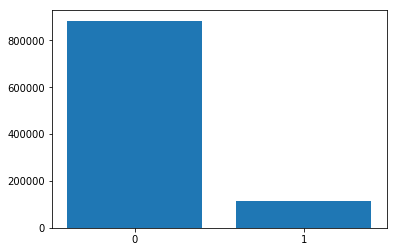

In [12]:
hist = results.histogram(key='x')

for k in hist:
    v = hist[k]
    hist[k] = v
    
print(hist)

plt.bar(range(len(hist)), hist.values(), align='center')
plt.xticks(range(len(hist)), list(hist.keys()))

plt.show()

Calculate the magnetization $M(J)$ from the measured outcomes by determining the relative frequency of each eigenstate and computing the expectation $\langle Y_{m} \rangle$:

In [13]:
f_1_meas = hist[0] / n
f_n1_meas = hist[1] / n

Y_meas = 1 * f_1_meas - 1 * f_n1_meas

M_meas = - Y_meas
M_meas

-0.7682720000000001

# Final Results
We can now compare our three results: the measured outcomes (finite number of runs), the wave function (limit of infinite runs), and the theoretical prediction given by the Ising model (Hebenstreait et al.):

In [14]:
M_theor = -0.81

err_wfn = 100 * (M_theor - M_wfn) / M_theor
err_meas = 100 * (M_theor - M_meas) / M_theor

err_wfn, err_meas

(5.147478984872145, 5.151604938271603)

Both of our results have about 5% error, which is consistent with the results of Hebenstreait et al. for a four-qubit spin chain simulation.


# Ising Circuit

Here, we run a much deeper, non-decomposed circuit. The benefit here is that rather than a specific circuit, we can produce circuits that simulate $n$ qubit ising chains with $m = log(n) + 1$ qubits accurately at the cost of circuit depth. The following is a circuit that simulates a four-qubit ising chain like above. The parameters for ising_circuit() are: $n$, the number of qubits in the simulation, $J$, the value we want to evolve our hamiltonian to, $J_{max}$, the highest $J$-value we expect to evolve to, $L$, the number of steps in our evolution minus one, and $T$, the total time for evolution.

In [15]:
simCircuit = ic.ising_circuit(4, 1, 2, 200, 10)
simCircuit

0: ───BF(0.5)─────────────────────┌--------┐───────────────@─────────────────┌--------┐─────────────────┌--------┐─────────────────────@─────────────────────────┌--------┐─────────────────┌--------┐─────────────────────@─────────────────────────┌--------┐─────────────────┌--------┐─────────────────────@─────────────────────────┌--------┐─────────────────┌--------┐─────────────────────@─────────────────────────┌--------┐─────────────────┌--------┐─────────────────────@─────────────────────────┌--------┐─────────────────┌--------┐─────────────────────@─────────────────────────┌--------┐─────────────────┌--------┐─────────────────────@─────────────────────────┌--------┐─────────────────┌--------┐─────────────────────@─────────────────────────┌--------┐─────────────────┌--------┐─────────────────────@─────────────────────────┌--------┐─────────────────┌--------┐───────────────────@───────────────────────┌--------┐─────────────────┌--------┐─────────────────────@─────────────────────────┌--------┐─────────────────┌--------┐─────────────────────@─────────────────────────┌--------┐─────────────────┌--------┐─────────────────────@─────────────────────────┌--------┐─────────────────┌--------┐─────────────────────@─────────────────────────┌--------┐─────────────────┌--------┐─────────────────────@─────────────────────────┌--------┐─────────────────┌--------┐─────────────────────@─────────────────────────┌--------┐─────────────────┌--------┐─────────────────────@─────────────────────────┌--------┐─────────────────┌--------┐─────────────────────@─────────────────────────┌--------┐─────────────────┌--------┐─────────────────────@─────────────────────────┌--------┐─────────────────┌--------┐───────────────────@───────────────────────┌--------┐─────────────────┌--------┐─────────────────────@─────────────────────────┌--------┐─────────────────┌--------┐─────────────────────@─────────────────────────┌--------┐─────────────────┌--------┐─────────────────────@─────────────────────────┌--------┐─────────────────┌--------┐─────────────────────@─────────────────────────┌--------┐─────────────────┌--------┐─────────────────────@─────────────────────────┌--------┐─────────────────┌--------┐─────────────────────@─────────────────────────┌--------┐─────────────────┌--------┐─────────────────────@─────────────────────────┌--------┐─────────────────┌--------┐─────────────────────@─────────────────────────┌--------┐─────────────────┌--------┐─────────────────────@─────────────────────────┌--------┐─────────────────┌--------┐───────────────────@───────────────────────┌--------┐─────────────────┌--------┐─────────────────────@─────────────────────────┌--------┐─────────────────┌--------┐─────────────────────@─────────────────────────┌--------┐─────────────────┌--------┐─────────────────────@─────────────────────────┌--------┐─────────────────┌--------┐─────────────────────@─────────────────────────┌--------┐─────────────────┌--------┐─────────────────────@─────────────────────────┌--------┐─────────────────┌--------┐─────────────────────@─────────────────────────┌--------┐─────────────────┌--------┐─────────────────────@─────────────────────────┌--------┐─────────────────┌--------┐─────────────────────@─────────────────────────┌--------┐─────────────────┌--------┐─────────────────────@─────────────────────────┌--------┐─────────────────┌--------┐─────────────────────@─────────────────────────┌--------┐─────────────────┌--------┐─────────────────────@─────────────────────────┌--------┐─────────────────┌--------┐─────────────────────@─────────────────────────┌--------┐─────────────────┌--------┐─────────────────────@─────────────────────────┌--------┐─────────────────┌--------┐─────────────────────@─────────────────────────┌--------┐─────────────────┌--------┐─────────────────────@─────────────────────────┌--------┐─────────────────┌--------┐─────────────────────@─────────────────────────┌--------┐─────────────────┌--------┐─────────────────────@────────────

In [16]:
simulator = cirq.Simulator()
result_new = simulator.run(simCircuit, repetitions=1000)
result_new

x=00000100000100000000000010000000000000000000000010000010100000000000000000000000001000001000000000000000000000100000000000001000000000000000011000000101100000000100001000010100100001000000000000000000000001000000000000000100000000000000000000000100101000000000010000000000100101000000001001000001010000000000000000000000000000100000000100000000000000010000000000010010000000000000000000000001001000000000000000000000000000000000000000000001000000000100000000000000000000000100000100000000000000100000000000000000000000000000000000111000100000000000010000000000000001001000000001000000000000010000000000010000100000000100000000000010000000000000001000000000000010000000000010000100010000010000000000000000000000001000001000010000000000000000000000010000000000001000000000000000000100000000000000000101000000000010000000010000000000100000010000001000000000010000010000000000000010010000000000000000000000000010001000000000000000000000000001000010000000000000010000000000000001000000001000001000000000

Counter({0: 910, 1: 90})


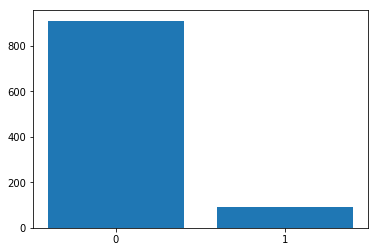

In [17]:
hist = result_new.histogram(key='x')

for k in hist:
    v = hist[k]
    hist[k] = v
    
print(hist)

plt.bar(range(len(hist)), hist.values(), align='center')
plt.xticks(range(len(hist)), list(hist.keys()))

plt.show()

In [18]:
f_1_meas = hist[0] / (hist[0] + hist[1])
f_n1_meas = hist[1] / (hist[0] + hist[1])

Y_meas = 1 * f_1_meas - 1 * f_n1_meas

M_meas = - Y_meas
M_meas

-0.8200000000000001

Again, we can compare the result of the circuit to the result theoretical result of the adiabatic evolution.

In [19]:
M_theor = -0.81

err_meas = 100 * (M_theor - M_meas) / M_theor

err_meas

-1.234567901234569

Here, we can see that with the larger, non-decomposed circuit, the results are more accurate at the cost of longer runtime.

# Calculate M(J) for J=0 to J=2

To make a comparison between the paper on "Compressed quantum computation using the IBM Quantum Experience", we will recreate the same graph for  $M(J)$ vs $J$ for $J=0$ to $J=2$.

In [59]:
j_vals = list(np.linspace(0, 2, 13))
j_vals

[0.0,
 0.16666666666666666,
 0.3333333333333333,
 0.5,
 0.6666666666666666,
 0.8333333333333333,
 1.0,
 1.1666666666666665,
 1.3333333333333333,
 1.5,
 1.6666666666666665,
 1.8333333333333333,
 2.0]

In [22]:
def run_circuit(circuits):
    return [simulator.run(circ, repetitions=1000) for circ in circuits]

def get_measurement_outcomes(j_vals, results):
    outcomes = dict()
    for i, r in enumerate(results):
        j = j_vals[i]
        hist = r.histogram(key='x')
        for k in hist:
            v = hist[k]
            hist[k] = v
        
        f_1_meas = hist[0] / (hist[0] + hist[1])
        f_n1_meas = hist[1] / (hist[0] + hist[1])
        Y_meas = 1 * f_1_meas - 1 * f_n1_meas
        M_meas = - Y_meas 
        outcomes[j] = M_meas
    
    return outcomes

In this case, our circuits will simulate 32 qubit ising chains with $L = 200$ and $t = 10$.

In [23]:
circuits = [ic.ising_circuit(32, j, 2, 200, 10) for j in j_vals]

data = [] # a list of the measurement outcomes
# mesaurement outcomes is a dictionary with J -> M(J)
# run the 1000 sims 50 times, take the average
# this takes 20 hours to run on a MBP, try importing the data.json file if interested.
# SKIP THIS BLOCK IF YOU WANT TO AVOID LONG WAIT, AND RUN THE NEXT BLOCK INSTEAD.
num_samples = 50
for _ in range(num_samples):
    results = run_circuit(circuits)
    measurement_outcomes = get_measurement_outcomes(j_vals, results)
    data.append(measurement_outcomes)
    
# Dump the JSON data
import json
with open('data.json', 'w') as outfile:
    json.dump(data, outfile)

In [64]:
# RUN THIS BLOCK TO USE PAST DATA
with open('data.json', 'r') as f:
    data = json.load(f)
    
data

[{'0.0': -1.0,
  '0.16666666666666666': -0.994,
  '0.3333333333333333': -0.972,
  '0.5': -0.938,
  '0.6666666666666666': -0.8839999999999999,
  '0.8333333333333333': -0.806,
  '1.0': -0.708,
  '1.1666666666666665': -0.6140000000000001,
  '1.3333333333333333': -0.474,
  '1.5': -0.42,
  '1.6666666666666665': -0.428,
  '1.8333333333333333': -0.29800000000000004,
  '2.0': -0.342},
 {'0.0': -1.0,
  '0.16666666666666666': -0.988,
  '0.3333333333333333': -0.964,
  '0.5': -0.9259999999999999,
  '0.6666666666666666': -0.8959999999999999,
  '0.8333333333333333': -0.782,
  '1.0': -0.6659999999999999,
  '1.1666666666666665': -0.6040000000000001,
  '1.3333333333333333': -0.514,
  '1.5': -0.43,
  '1.6666666666666665': -0.434,
  '1.8333333333333333': -0.38999999999999996,
  '2.0': -0.40599999999999997},
 {'0.0': -1.0,
  '0.16666666666666666': -0.99,
  '0.3333333333333333': -0.97,
  '0.5': -0.946,
  '0.6666666666666666': -0.9019999999999999,
  '0.8333333333333333': -0.8260000000000001,
  '1.0': -0.742

In [68]:
# get the average M(J) and std dev
avg_data = dict() # J -> (M(J) stddev, M(J) avg)
for j in list(map(str, j_vals)):
    m_vals = []
    for d in data:
        m = d[j]
        m_vals.append(m)
    stddev = np.std(m_vals)
    mean = np.mean(m_vals)
    avg_data[j] = (stddev, mean)
    
avg_data

{'0.0': (0.0, -1.0),
 '0.16666666666666666': (0.003258465896706611, -0.99232),
 '0.3333333333333333': (0.006808112807526039, -0.9743599999999998),
 '0.5': (0.011151035826325742, -0.9328799999999999),
 '0.6666666666666666': (0.01679638056249018, -0.8849600000000001),
 '0.8333333333333333': (0.018391693777355052, -0.81316),
 '1.0': (0.023007789985133316, -0.71396),
 '1.1666666666666665': (0.024318585485179803, -0.60508),
 '1.3333333333333333': (0.0327029050697335, -0.48379999999999995),
 '1.5': (0.027969268849935985, -0.4278),
 '1.6666666666666665': (0.027376369372142814, -0.39112),
 '1.8333333333333333': (0.03456935058689993, -0.35400000000000004),
 '2.0': (0.026724550510719522, -0.35472000000000004)}

In [73]:
J, M = zip(*avg_data.items())
J = list(map(float, J))
stddev_M, mean_M = list(zip(*M)) 
print("J values:", J)
print("M(J) avg:", mean_M)
print("M(J) stddev:", stddev_M)

J values: [0.0, 0.16666666666666666, 0.3333333333333333, 0.5, 0.6666666666666666, 0.8333333333333333, 1.0, 1.1666666666666665, 1.3333333333333333, 1.5, 1.6666666666666665, 1.8333333333333333, 2.0]
M(J) avg: (-1.0, -0.99232, -0.9743599999999998, -0.9328799999999999, -0.8849600000000001, -0.81316, -0.71396, -0.60508, -0.48379999999999995, -0.4278, -0.39112, -0.35400000000000004, -0.35472000000000004)
M(J) stddev: (0.0, 0.003258465896706611, 0.006808112807526039, 0.011151035826325742, 0.01679638056249018, 0.018391693777355052, 0.023007789985133316, 0.024318585485179803, 0.0327029050697335, 0.027969268849935985, 0.027376369372142814, 0.03456935058689993, 0.026724550510719522)


In [ ]:
# J, M = zip(*measurement_outcomes.items())
# plt.plot(J, M, 'r+')
# plt.xlim(0, 2)  # decreasing time
# plt.grid(True)
# plt.title('Cirq Quantum Compression')
# plt.xlabel('J')
# plt.ylabel('M(J)')
# plt.xticks(list(np.linspace(0, 2, 5)))
# plt.yticks(list(np.linspace(-1, 0, 6)))

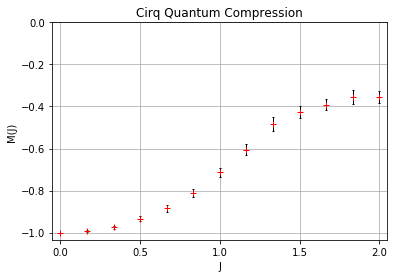

In [74]:
# 50 runs of 1000 repetitions on circuit, plotted with avg and stddev
plt.errorbar(J, mean_M, yerr=stddev_M, fmt='+', color='r',
             ecolor='black', elinewidth=1, capsize=1);
plt.xlim(-0.05, 2.05)  # decreasing time
plt.grid(True)
plt.title('Cirq Quantum Compression')
plt.xlabel('J')
plt.ylabel('M(J)')
plt.xticks(list(np.linspace(0, 2, 5)))
plt.yticks(list(np.linspace(-1, 0, 6)))
plt.savefig('final_result.png', dpi=288)

In [21]:
import isingCircuitTests as iTest